In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from datetime import datetime
from functools import reduce 
from scipy import stats

import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
import pandas_datareader.data as web
from pandas_datareader import data as pdr

# ACF plot of standardized residuals
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Import cryptocmd to get BTC data
from cryptocmd import CmcScraper
import yfinance as yf
from arch import arch_model

%matplotlib inline

# Set seaborn plot style
sns.set_style("darkgrid")
# Set matplotlib plot style
style.use("seaborn-talk")

In [2]:
def get_stock_data(stock_name):
    data = yf.Ticker(stock_name).history(period='10y')
    data = pd.DataFrame(data, columns=['Close'])
    data = data.rename(columns = {'Close':stock_name})    
    return data

def get_crypto_data(coin_name):
    scraper = CmcScraper(coin_name)
    coin_df = scraper.get_dataframe()
    coin_df = pd.DataFrame(coin_df, columns=['Date','Close'])
    coin_df.set_index('Date', inplace=True)
    coin_df = coin_df.rename(columns = {'Close':coin_name})
    coin_df = coin_df.iloc[::-1]
    return coin_df

def get_sp500_data():
    start = datetime(2010, 4, 28)
    sp500 = web.DataReader(['sp500'], 'fred', start)
    return sp500

In [3]:
#crypto_list = ['BTC', 'ETH', 'MATIC']
crypto_list = ['BTC', 'ETH', 'MATIC', 'SOL', 'AVAX', 'DOT']

In [4]:
crypto_df = pd.concat([get_crypto_data(x) for x in crypto_list], axis=1)
crypto_df

,BTC,ETH,MATIC,SOL,AVAX,DOT
Date,,,,,,
2013-04-28,134.210007,NaN,NaN,NaN,NaN,NaN
2013-04-29,144.539993,NaN,NaN,NaN,NaN,NaN
2013-04-30,139.000000,NaN,NaN,NaN,NaN,NaN
2013-05-01,116.989998,NaN,NaN,NaN,NaN,NaN
2013-05-02,105.209999,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-04-04,46622.674414,3521.241137,1.649918,132.412627,95.520216,22.657770
2022-04-05,45555.993404,3411.792509,1.592921,126.862236,91.021093,21.789714
2022-04-06,43206.737673,3171.692010,1.458747,112.883387,82.955908,19.839634


In [5]:
btc_df = get_crypto_data('BTC')

In [6]:
google_df = get_stock_data('TSLA')

In [7]:
sp500_df = get_sp500_data()
#sp500_df = get_stock_data('^GSPC')

In [8]:
portfolio_df = pd.concat([crypto_df,google_df,sp500_df],axis=1)
#portfolio_df.dropna(inplace=True)
portfolio_df

,BTC,ETH,MATIC,SOL,AVAX,DOT,TSLA,sp500
2012-04-09,NaN,NaN,NaN,NaN,NaN,NaN,6.630000,1382.20
2012-04-10,NaN,NaN,NaN,NaN,NaN,NaN,6.492000,1358.59
2012-04-11,NaN,NaN,NaN,NaN,NaN,NaN,6.618000,1368.71
2012-04-12,NaN,NaN,NaN,NaN,NaN,NaN,6.688000,1387.57
2012-04-13,NaN,NaN,NaN,NaN,NaN,NaN,6.718000,1370.26
...,...,...,...,...,...,...,...,...
2022-04-04,46622.674414,3521.241137,1.649918,132.412627,95.520216,22.657770,1145.449951,4582.64
2022-04-05,45555.993404,3411.792509,1.592921,126.862236,91.021093,21.789714,1091.260010,4525.12
2022-04-06,43206.737673,3171.692010,1.458747,112.883387,82.955908,19.839634,1045.760010,4481.15
2022-04-07,43503.849166,3233.274707,1.514054,118.796515,87.919709,20.426392,1057.260010,4500.21


In [9]:
def get_return(price_df, colname):
    if colname != 'sp500':
        tmp_df = pd.DataFrame(price_df, columns=[colname,'sp500']).dropna()
        tmp_df = np.log(tmp_df).diff().mul(100)
    else :
        tmp_df = pd.DataFrame(price_df, columns=[colname]).dropna()
        tmp_df = np.log(tmp_df).diff().mul(100)       

    return_df = pd.DataFrame(tmp_df, columns=[colname])       

    return return_df

In [10]:
portfolio_return_df = pd.concat([get_return(portfolio_df, x) for x in portfolio_df.keys()], axis=1)
portfolio_return_df

,BTC,ETH,MATIC,SOL,AVAX,DOT,TSLA,sp500
2012-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-10,NaN,NaN,NaN,NaN,NaN,NaN,-2.103416,-1.722904
2012-04-11,NaN,NaN,NaN,NaN,NaN,NaN,1.922255,0.742129
2012-04-12,NaN,NaN,NaN,NaN,NaN,NaN,1.052169,1.368533
2012-04-13,NaN,NaN,NaN,NaN,NaN,NaN,0.447558,-1.255351
...,...,...,...,...,...,...,...,...
2022-04-04,0.734157,2.056912,-2.631618,-1.512756,-1.220498,2.868858,5.459553,0.805832
2022-04-05,-2.314480,-3.157571,-3.515609,-4.282127,-4.824663,-3.906483,-4.846453,-1.263116
2022-04-06,-5.294575,-7.297261,-8.799129,-11.674643,-9.278204,-9.375635,-4.258910,-0.976439
2022-04-07,0.685297,1.923026,3.721274,5.105676,5.811477,2.914613,1.093676,0.424435


In [11]:
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum((series_log_return)**2)/(n - 1))

def get_volatility(return_df, t_window):
    volatility_df = {}
    for colname in return_df:    
        vols = return_df[colname].rolling(window=t_window).apply(realized_volatility_daily).values
        volatility_df[colname] = vols
        
    volatility_df = pd.DataFrame(volatility_df, index=return_df.index)        
    return volatility_df

In [12]:
portfolio_volatility_df = get_volatility(portfolio_return_df, 180)
portfolio_volatility_df

,BTC,ETH,MATIC,SOL,AVAX,DOT,TSLA,sp500
2012-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022-04-04,3.984664,4.836636,7.023088,7.063090,8.287924,6.616750,3.614829,1.023796
2022-04-05,3.980626,4.840815,7.014985,7.064022,8.286515,6.616559,3.629259,1.021968
2022-04-06,3.961372,4.804350,6.789021,7.055907,8.295667,6.598885,3.642712,1.022732
2022-04-07,3.961424,4.804811,6.794424,7.059977,8.302068,6.583336,3.642974,1.023113


In [13]:
def market_beta(X,Y,N):
    """ 
    X = The independent variable which is the Market
    Y = The dependent variable which is the Stock
    N = The length of the Window
    
    It returns the alphas and the betas of
    the rolling regression
    """
    
    # all the observations
    obs = len(X)
    
    # initiate the betas with null values
    betas = np.full(obs, np.nan)
    
    # initiate the alphas with null values
    alphas = np.full(obs, np.nan)
    
    for i in range((obs-N)):
        regressor = LinearRegression()
        regressor.fit(X.to_numpy()[i : i + N+1].reshape(-1,1), Y.to_numpy()[i : i + N+1])
        betas[i+N]  = regressor.coef_[0]
        alphas[i+N]  = regressor.intercept_
        Y_pred = regressor.predict(X.to_numpy()[i : i + N+1].reshape(-1,1))
        
    #return(alphas, betas)
    return betas

def get_beta(return_df, colname, t_window):
    tmp_df = pd.DataFrame(return_df, columns=[colname, 'sp500']).dropna()
    results = market_beta(tmp_df['sp500'], tmp_df[colname], t_window)
        
    beta_df = pd.DataFrame(results, index=tmp_df.index, columns=[colname])       
    return beta_df

In [14]:
portfolio_beta_df = pd.concat([get_beta(portfolio_return_df, x, 180) for x in portfolio_return_df.keys()[:-1]], axis=1)
portfolio_beta_df

,BTC,ETH,MATIC,SOL,AVAX,DOT,TSLA
2012-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-04-04,1.469226,2.165818,2.832602,2.395486,2.057492,2.492709,1.830161
2022-04-05,1.475612,2.168667,2.779013,2.370356,2.042365,2.485607,1.875063
2022-04-06,1.542166,2.238645,2.894037,2.490778,2.161819,2.586987,1.895963
2022-04-07,1.516120,2.202999,2.802297,2.456381,2.149570,2.551793,1.907114


In [15]:
def plot_beta_alone(beta_df):
    plt.style.use('classic')
    for colname in beta_df:         
        fig, ax1 = plt.subplots(figsize=(13, 6))
        ax1.grid(True)
        ax1.plot(beta_df.index, beta_df[colname], color='grey', lw=3, label=colname)
        ax1.set(title='Rolling Beta to S&P 500 (6 month)', ylabel='Beta')
        plt.legend(loc='best', prop={'size': 14},  frameon=False)    
        fig.savefig(f'images/{colname}_beta.png')

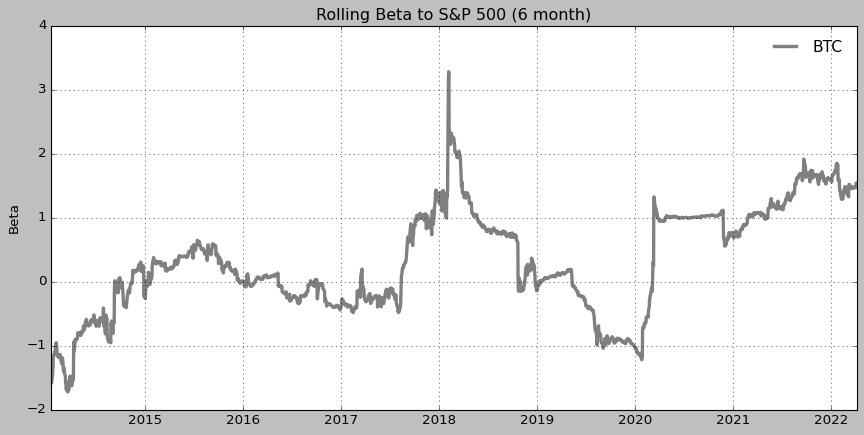

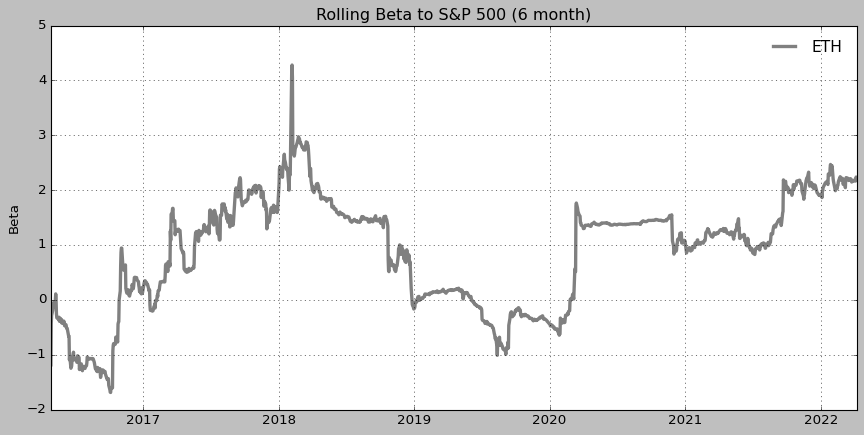

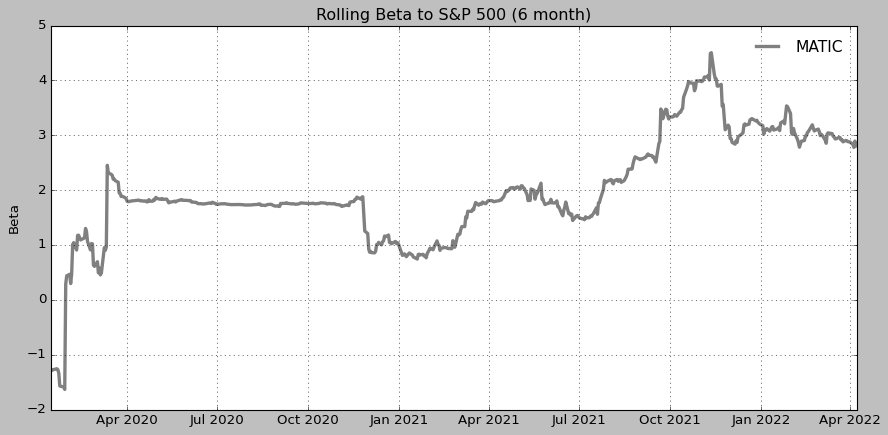

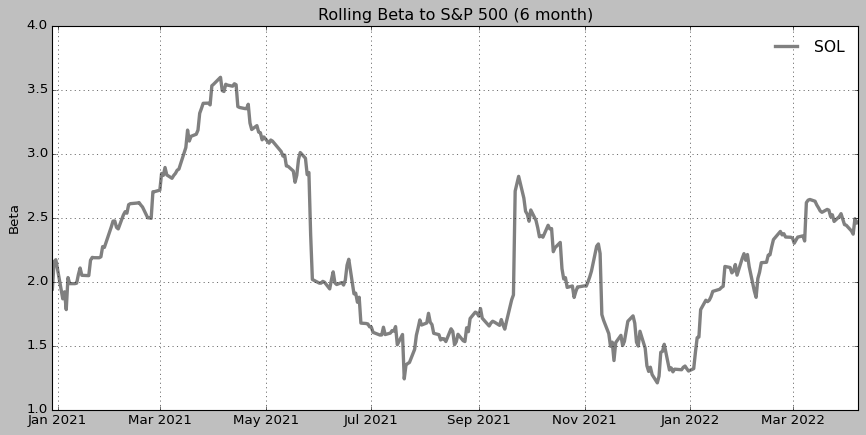

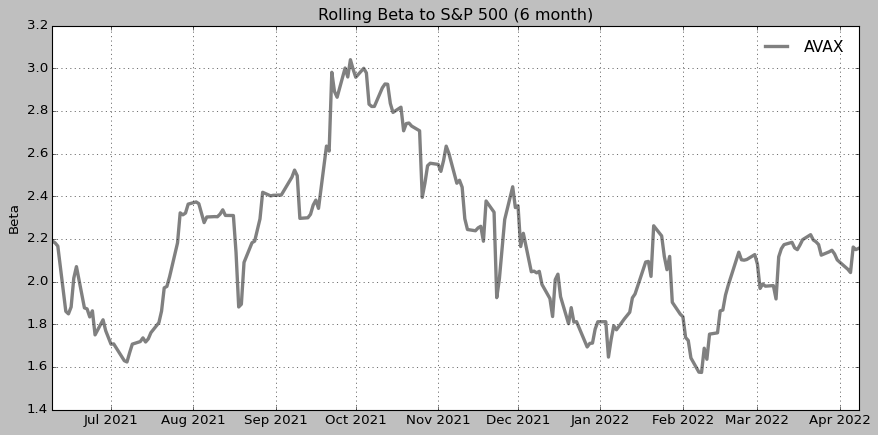

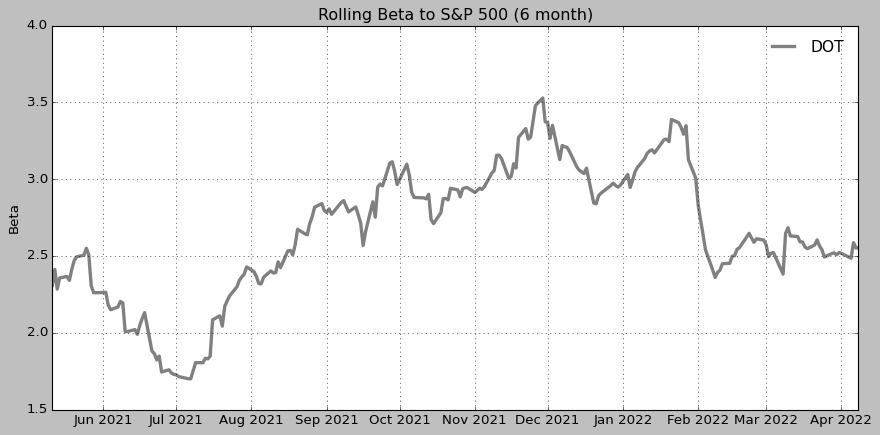

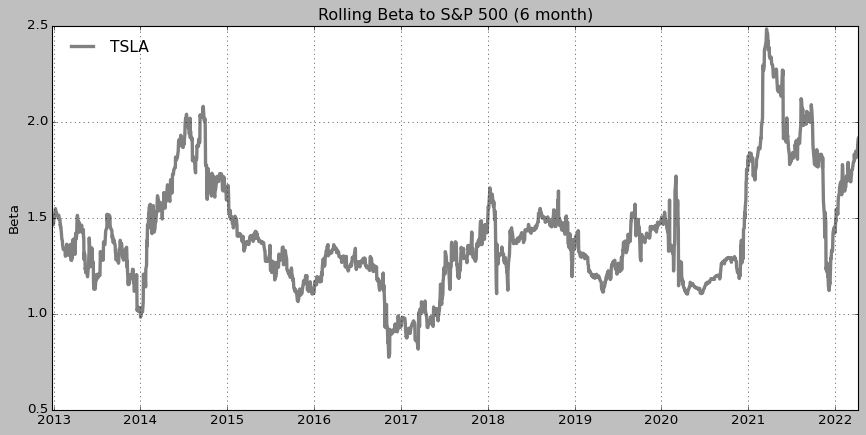

In [16]:
plot_beta_alone(portfolio_beta_df)

In [209]:
color = [
'red', 
'skyblue', 
'yellowgreen', 
'violet',
'darkcyan',   
'hotpink', 
'navy',
'grey', 
'burlywood',
'lightgreen'
]

def plot_beta(beta_df):
    plt.style.use('classic')
    fig, ax1 = plt.subplots(figsize=(13, 6))
    ax1.grid(True)
    for idx, colname in enumerate(beta_df.iloc[:, :]): 
        ax1.plot(beta_df.index, beta_df[colname], lw=3, label=colname, color=color[idx])
    ax1.set(title='Rolling Beta to S&P 500 (6 month)', ylabel='Beta')
    plt.legend(loc='best', prop={'size': 14},  frameon=False, ncol=2)    
    fig.savefig(f'images/beta.png')

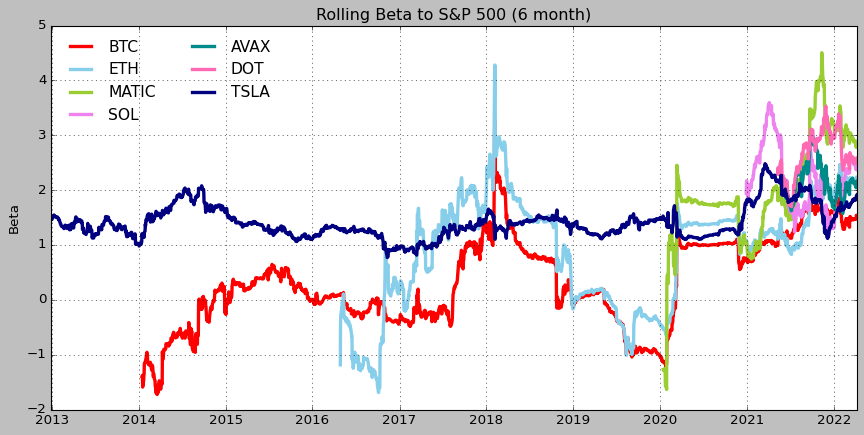

In [219]:
plot_beta(portfolio_beta_df)

In [211]:
def plot_volatility_alone(volatility_df):
    plt.style.use('classic')
    for colname in volatility_df:     
        fig, ax1 = plt.subplots(figsize=(13, 6))
        ax1.grid(True)
        ax1.plot(volatility_df.index, volatility_df[colname], color='Red', lw=3, label=colname,)
        ax1.plot(volatility_df.index, volatility_df['sp500'], color='grey', lw=3, label='S&P 500', alpha=1)   
        ax1.set(title='Rolling Volatility (6 month)', ylabel='Volatility (%)')
        plt.legend(loc='best', prop={'size': 14},  frameon=False)    
        fig.savefig(f'images/{colname}_volatility.png')

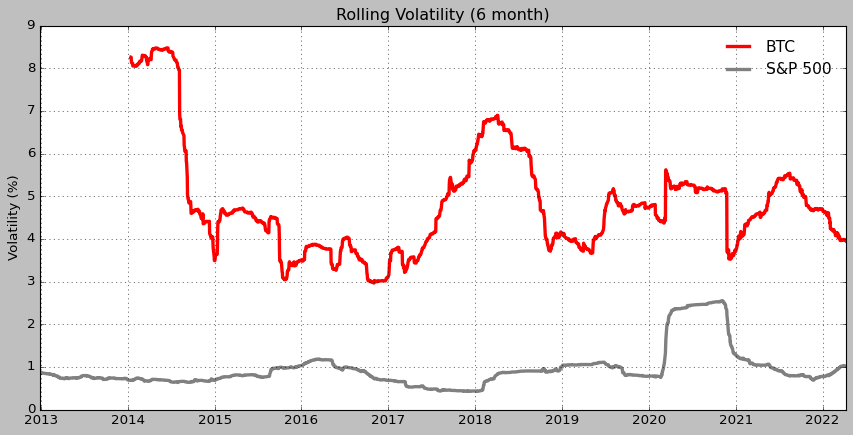

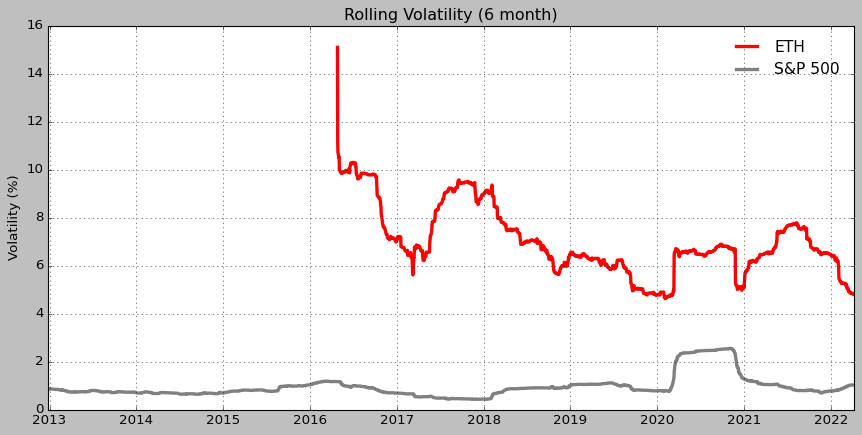

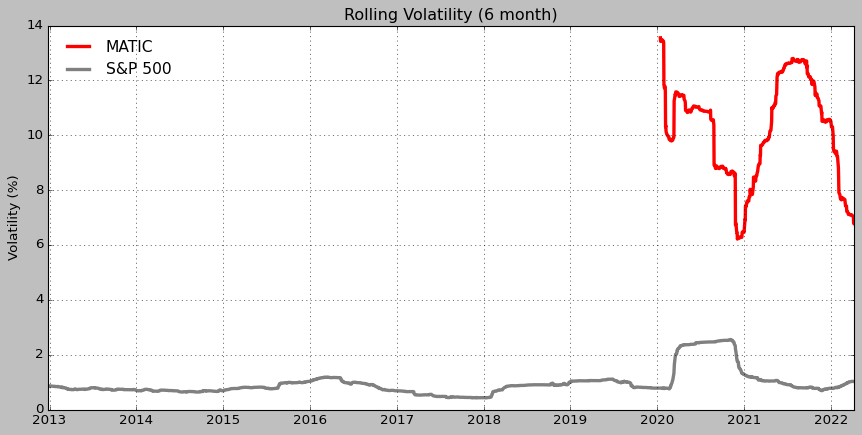

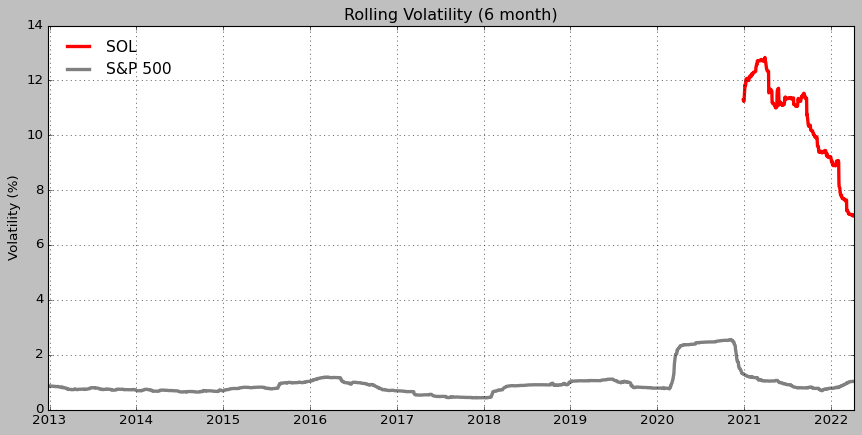

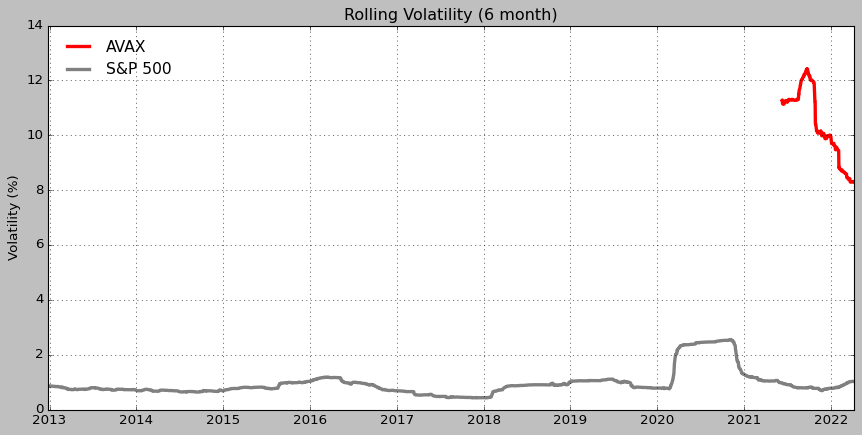

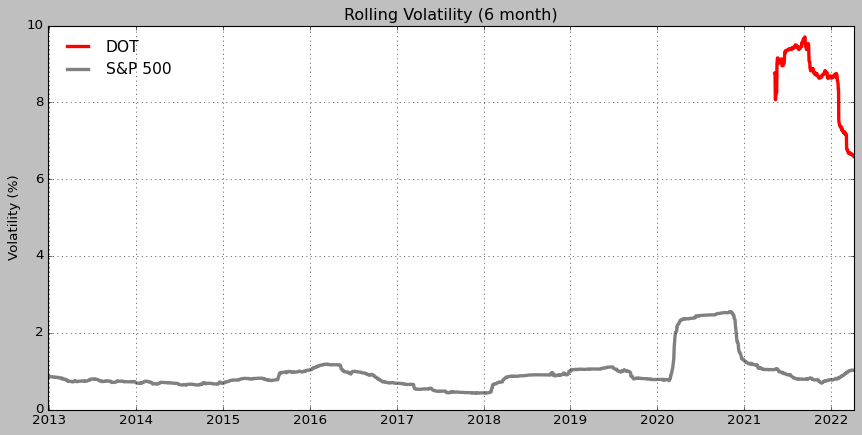

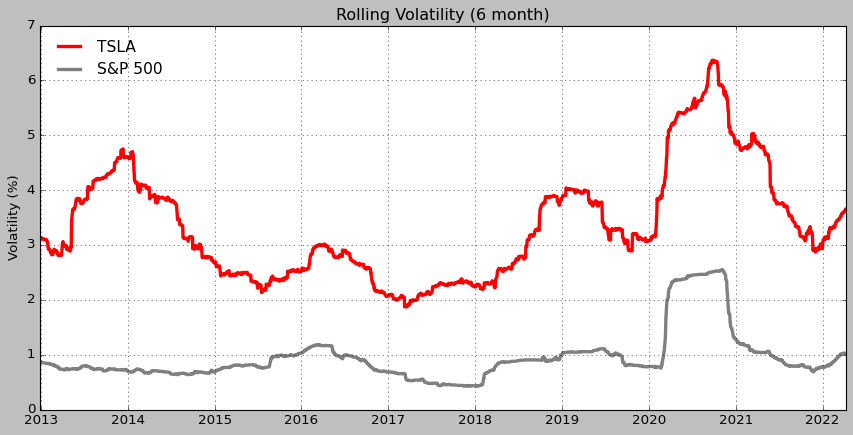

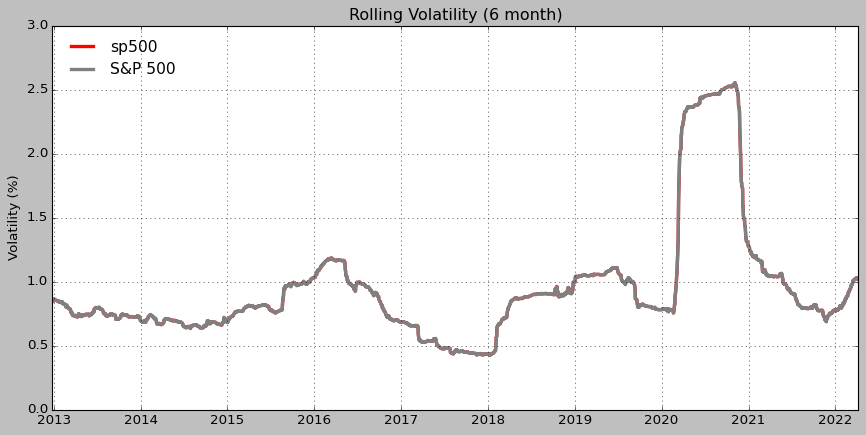

In [212]:
plot_volatility_alone(portfolio_volatility_df)

In [213]:
def plot_volatility(volatility_df):
    plt.style.use('classic')
    fig, ax1 = plt.subplots(figsize=(13, 6))
    ax1.grid(True)
    for idx, colname in enumerate(volatility_df): 
        ax1.plot(volatility_df.index, volatility_df[colname], lw=3, label=colname, color=color[idx])
    ax1.set(title='Rolling Volatility (6 month)', ylabel='Volatility (%)')
    plt.legend(loc='best', prop={'size': 14},  frameon=False, ncol=2)    
    fig.savefig(f'images/volatility.png')

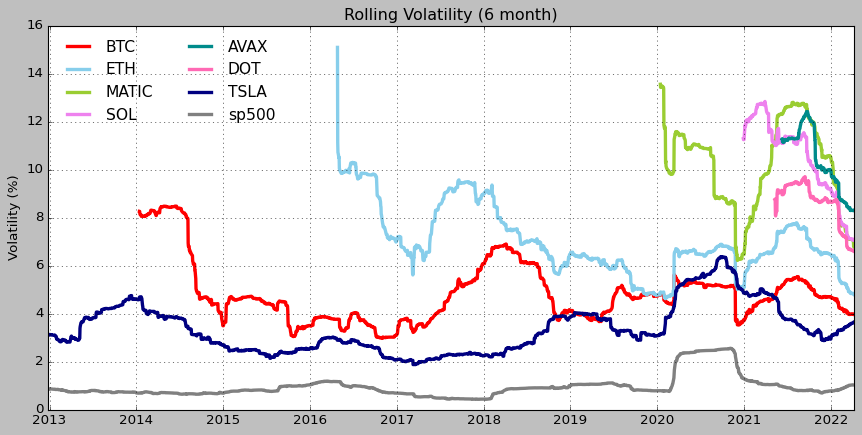

In [220]:
plot_volatility(portfolio_volatility_df)

In [170]:
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import kstest
from scipy.optimize import curve_fit
from pylab import exp,hist,sqrt,diag

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu,sigma1,A1,sigma2,A2):
    return gauss(x,mu,sigma1,A1)+gauss(x,mu,sigma2,A2)

def tripmodal(x,mu,sigma1,A1,sigma2,A2,sigma3,A3):
    return gauss(x,mu,sigma1,A1)+gauss(x,mu,sigma2,A2)+gauss(x,mu,sigma3,A3)

def distribution(return_df, colname):
    tmp_df = return_df[colname].dropna()
    plt.style.use('classic')
    fig, ax1 = plt.subplots(figsize=(10, 8))
    ax1.grid(True)
    
    cont, bins, _ = ax1.hist(tmp_df, bins=100, density=True, histtype='stepfilled', alpha=0.1, label='data')
    mu, std = norm.fit(tmp_df)
    best_fit_norm = norm.pdf(bins, mu, std)
    plt.plot(bins, best_fit_norm, color='blue', lw=3, label='Norm')

    ax1.set(title=f'{colname} Return Distribution', ylabel='Density', xlabel='return (%)')    
    #plt.plot(bins[:-1], cont)
        
    mean, var, skew = t.fit(tmp_df)
    best_fit_t = t.pdf(bins, mean, var, skew)
    plt.plot(bins, best_fit_t, color='green', lw=3, label='t')    

    y,x,_=hist(tmp_df,100,alpha=.1,density=1)
    x=(x[1:]+x[:-1])/2 # for len(x)==len(y)    
    params,cov=curve_fit(bimodal,x,y,[0,1,20,5,10])
    print(params)
    #sigma=sqrt(diag(cov))
    plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
    
    
#     print(params,'\n',sigma)  
    std=5
    ax1.set_xlim([-4*std, 4*std])
    ax1.set(title=f'{colname} Return Distribution', ylabel='Density', xlabel='return (%)')    

    
    
    plt.legend(loc='best', prop={'size': 14},  frameon=False)  
    fig.savefig(f'images/{colname}_return.png')

[0.15927595 1.38237635 0.11518985 5.028188   0.04572281]
[-0.14656489  2.08662907  0.0576131   6.50719403  0.04052481]
[-0.0997227   4.4022454   0.03960622  9.76457386  0.02192061]
[-0.02022091  2.3954011   0.01213404  8.12013464  0.0438666 ]
[ 0.26030952  0.92121236 -0.02234993  6.66980289  0.0589899 ]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

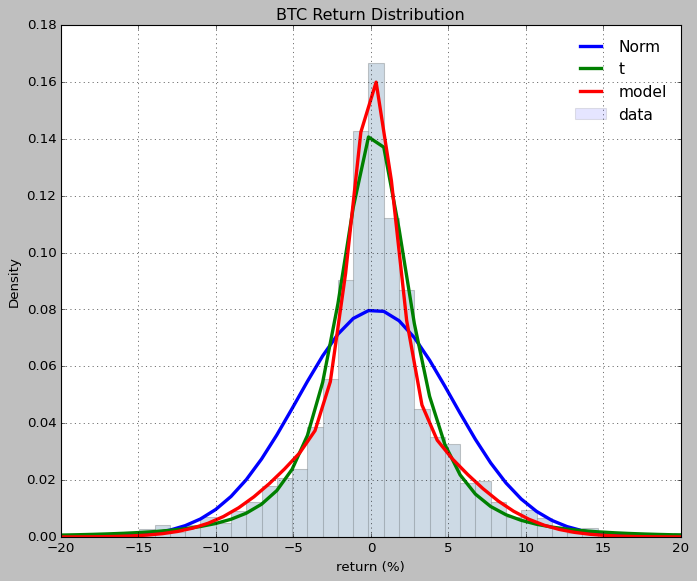

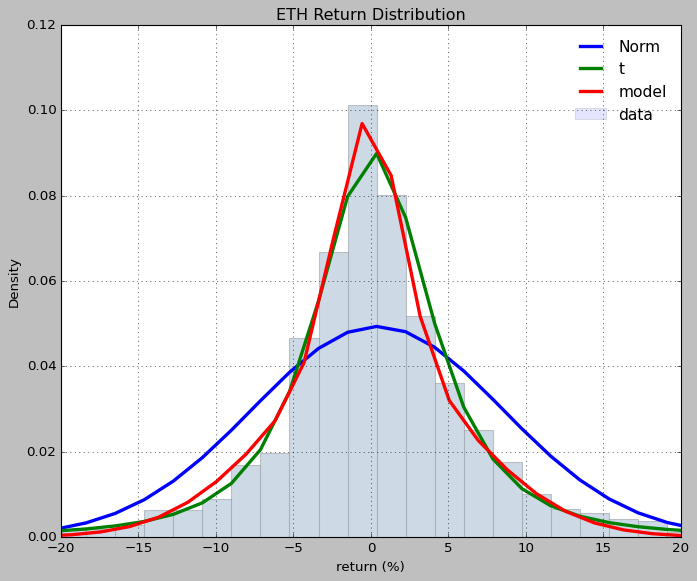

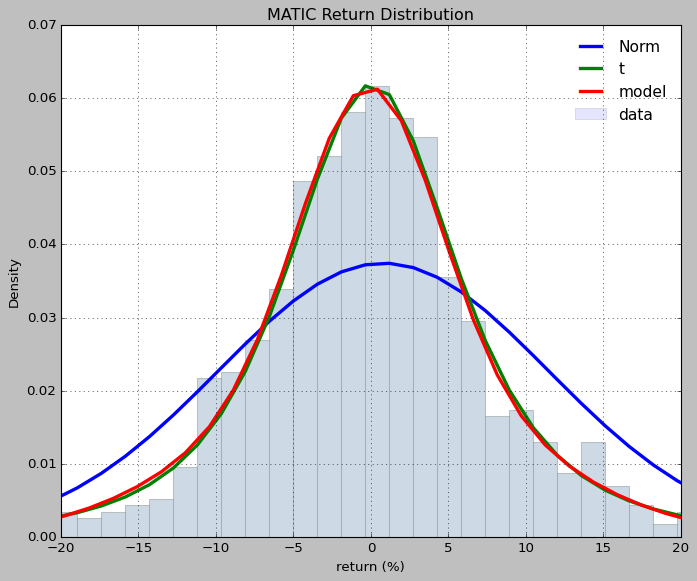

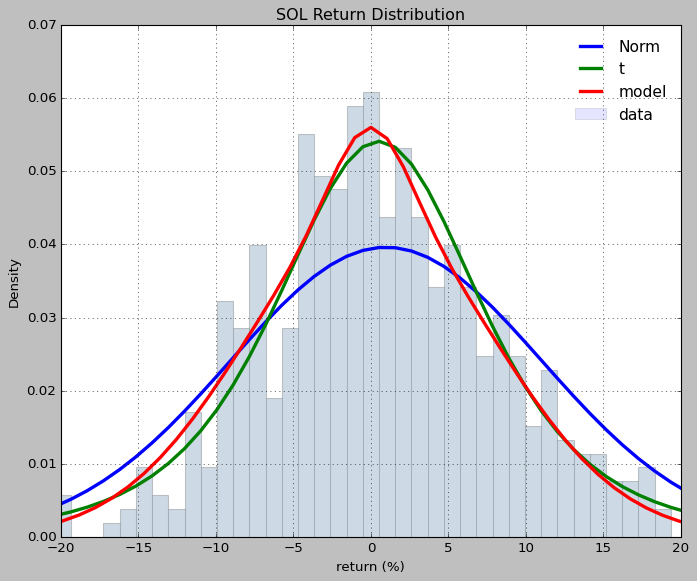

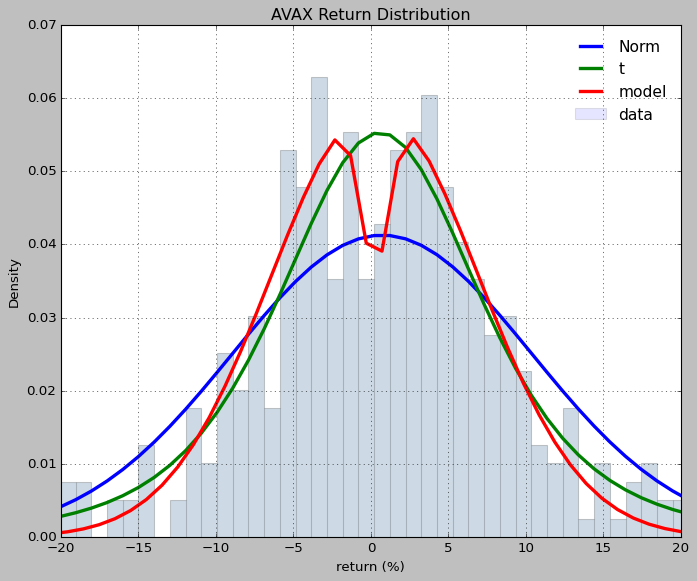

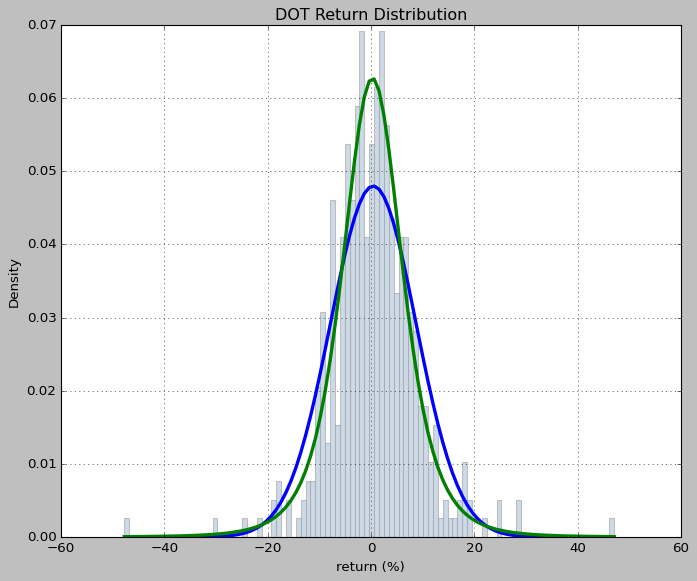

In [173]:
[distribution(portfolio_return_df, x) for x in portfolio_return_df.keys()]

## Crypto Marker Risk

In [25]:
def scraper_coins(coins_name):
    coins_df = pd.DataFrame(columns=['Date'])
    print("In total %d coins to scraper" % (len(coins_name)))
    for i, coins in enumerate(coins_name):
        print("Start with %d coin: %s" % (i, coins))
        scraper = CmcScraper(coins)
        tmp_coins_df = scraper.get_dataframe()
        tmp_coins_df = pd.DataFrame(tmp_coins_df, columns=['Date','Close', 'Market Cap'])
        tmp_coins_df = tmp_coins_df.rename(columns = {'Close':coins+' Close'})
        tmp_coins_df = tmp_coins_df.rename(columns = {'Market Cap':coins+' Market Cap'})
        coins_df = coins_df.merge(tmp_coins_df, on='Date', how='outer')
    
    coins_df.set_index('Date', inplace=True)
    coins_df = coins_df.fillna(0)
    coins_df = coins_df.iloc[::-1]
    return coins_df

def weighted_coins_index(coins_name, coins_df, index_name):
    for coins in coins_name:
        w = coins_df[coins+' Market Cap'] / coins_df['Total Market Cap']
        #p = coins_df[coins+' Close']
        p = coins_df[coins+' Close'] / coins_df[coins+' Close'].iloc[-1]        
        coins_df[index_name] += w * p

    coins_df[index_name] /= coins_df[index_name].iloc[0]
    return coins_df

In [26]:
top10crypto_list = ['BTC', 'ETH', 'BNB', 'SOL', 'XRP', 'LUNA', 'ADA', 'AVAX', 'DOT', 'DOGE']
top10crypto_df = scraper_coins(top10crypto_list)
top10crypto_df['Total Market Cap'] = top10crypto_df.loc[:, top10crypto_df.columns.str.endswith('Market Cap')].sum(1)
top10crypto_df['Top10CoinIndex'] = 0

In total 10 coins to scraper
Start with 0 coin: BTC
Start with 1 coin: ETH
Start with 2 coin: BNB
Start with 3 coin: SOL
Start with 4 coin: XRP
Start with 5 coin: LUNA
Start with 6 coin: ADA
Start with 7 coin: AVAX
Start with 8 coin: DOT
Start with 9 coin: DOGE


In [27]:
top10crypto_df = weighted_coins_index(top10crypto_list, top10crypto_df, 'Top10CoinIndex')
top10cryptoindex_df = pd.DataFrame(top10crypto_df, columns=['Top10CoinIndex'])

In [28]:
ethereumbased_list = ['MATIC', 'SOL', 'AVAX', 'DOT']
ethereumbased_df = scraper_coins(ethereumbased_list)
ethereumbased_df['Total Market Cap'] = ethereumbased_df.loc[:, ethereumbased_df.columns.str.endswith('Market Cap')].sum(1)
ethereumbased_df = ethereumbased_df[ethereumbased_df['Total Market Cap'] > 0]
ethereumbased_df['EthBasedCoinIndex'] = 0
ethereumbased_df

In total 4 coins to scraper
Start with 0 coin: MATIC
Start with 1 coin: SOL
Start with 2 coin: AVAX
Start with 3 coin: DOT


,MATIC Close,MATIC Market Cap,SOL Close,SOL Market Cap,AVAX Close,AVAX Market Cap,DOT Close,DOT Market Cap,Total Market Cap,EthBasedCoinIndex
Date,,,,,,,,,,
2019-05-08,0.003352,7.239723e+06,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,7.239723e+06,0
2019-05-09,0.003141,6.785407e+06,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,6.785407e+06,0
2019-05-10,0.003770,8.144299e+06,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,8.144299e+06,0
2019-05-11,0.004608,9.954513e+06,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,9.954513e+06,0
2019-05-12,0.005273,1.139051e+07,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,1.139051e+07,0
...,...,...,...,...,...,...,...,...,...,...
2022-04-04,1.649918,1.280087e+10,132.412627,4.311330e+10,95.520216,2.554076e+10,22.657770,2.237634e+10,1.038313e+11,0
2022-04-05,1.592921,1.235866e+10,126.862236,4.132265e+10,91.021093,2.439297e+10,21.789714,2.151907e+10,9.959335e+10,0
2022-04-06,1.458747,1.131768e+10,112.883387,3.676929e+10,82.955908,2.223108e+10,19.839634,1.959321e+10,8.991126e+10,0


In [29]:
ethereumbased_df = weighted_coins_index(ethereumbased_list, ethereumbased_df, 'EthBasedCoinIndex')
ethbasedcoinindex_df = pd.DataFrame(ethereumbased_df, columns=['EthBasedCoinIndex'])
ethbasedcoinindex_df

,EthBasedCoinIndex
Date,
2019-05-08,1.000000
2019-05-09,0.937247
2019-05-10,1.124946
2019-05-11,1.374985
2019-05-12,1.573335
...,...
2022-04-04,503.158046
2022-04-05,482.287856
2022-04-06,435.236183


In [30]:
cryptoindex_df = pd.concat([top10cryptoindex_df,ethbasedcoinindex_df,sp500_df],axis=1)
cryptoindex_df

,Top10CoinIndex,EthBasedCoinIndex,sp500
2012-04-09,NaN,NaN,1382.20
2012-04-10,NaN,NaN,1358.59
2012-04-11,NaN,NaN,1368.71
2012-04-12,NaN,NaN,1387.57
2012-04-13,NaN,NaN,1370.26
...,...,...,...
2022-04-04,349.572357,503.158046,4582.64
2022-04-05,341.719481,482.287856,4525.12
2022-04-06,320.013088,435.236183,4481.15
2022-04-07,324.490544,455.870512,4500.21


In [31]:
cryptoindex_return_df = pd.concat([get_return(cryptoindex_df, x) for x in cryptoindex_df.keys()], axis=1)
cryptoindex_return_df

,Top10CoinIndex,EthBasedCoinIndex,sp500
2012-04-09,NaN,NaN,NaN
2012-04-10,NaN,NaN,-1.722904
2012-04-11,NaN,NaN,0.742129
2012-04-12,NaN,NaN,1.368533
2012-04-13,NaN,NaN,-1.255351
...,...,...,...
2022-04-04,1.332848,-0.695784,0.805832
2022-04-05,-2.272040,-4.236318,-1.263116
2022-04-06,-6.562828,-10.265231,-0.976439
2022-04-07,1.389450,4.631997,0.424435


In [32]:
cryptoindex_volatility_df = get_volatility(cryptoindex_return_df, 180)
cryptoindex_volatility_df

,Top10CoinIndex,EthBasedCoinIndex,sp500
2012-04-09,NaN,NaN,NaN
2012-04-10,NaN,NaN,NaN
2012-04-11,NaN,NaN,NaN
2012-04-12,NaN,NaN,NaN
2012-04-13,NaN,NaN,NaN
...,...,...,...
2022-04-04,4.166562,5.780680,1.023796
2022-04-05,4.162501,5.780196,1.021968
2022-04-06,4.143189,5.715905,1.022732
2022-04-07,4.143864,5.716195,1.023113


In [33]:
cryptoindex_beta_df = pd.concat([get_beta(cryptoindex_return_df, x, 180) for x in cryptoindex_return_df.keys()[:-1]], axis=1)
cryptoindex_beta_df

,Top10CoinIndex,EthBasedCoinIndex
2013-04-30,NaN,NaN
2013-05-01,NaN,NaN
2013-05-02,NaN,NaN
2013-05-03,NaN,NaN
2013-05-06,NaN,NaN
...,...,...
2022-04-04,1.731927,2.392033
2022-04-05,1.733584,2.374764
2022-04-06,1.808870,2.485404
2022-04-07,1.780651,2.436754


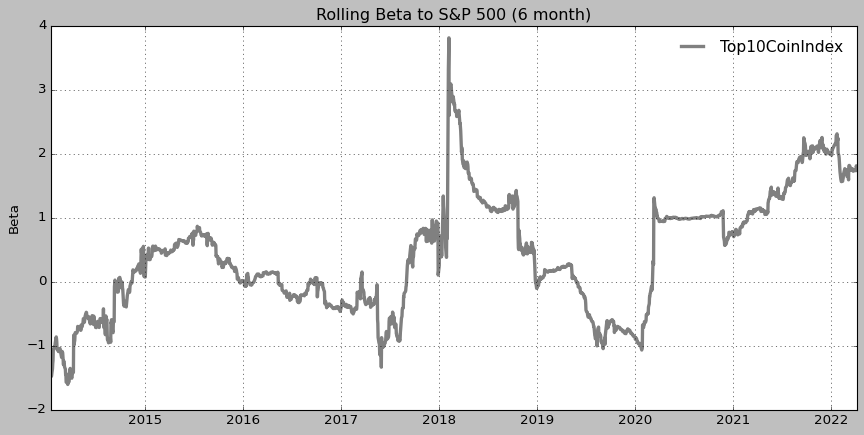

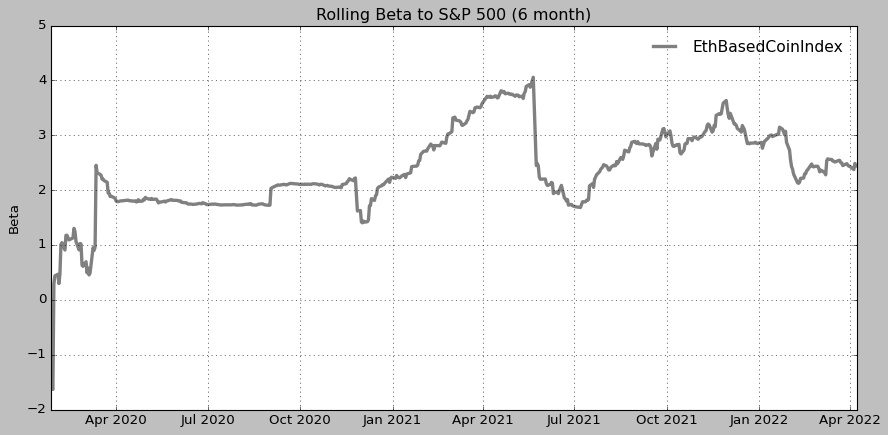

In [215]:
plot_beta_alone(cryptoindex_beta_df)

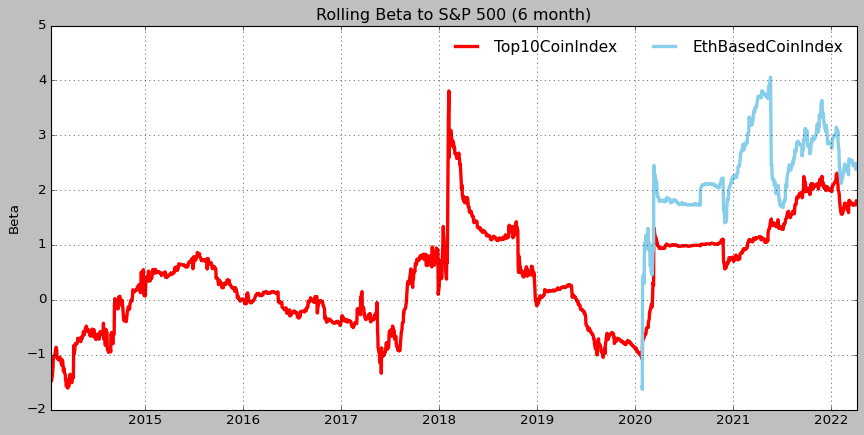

In [216]:
plot_beta(cryptoindex_beta_df)

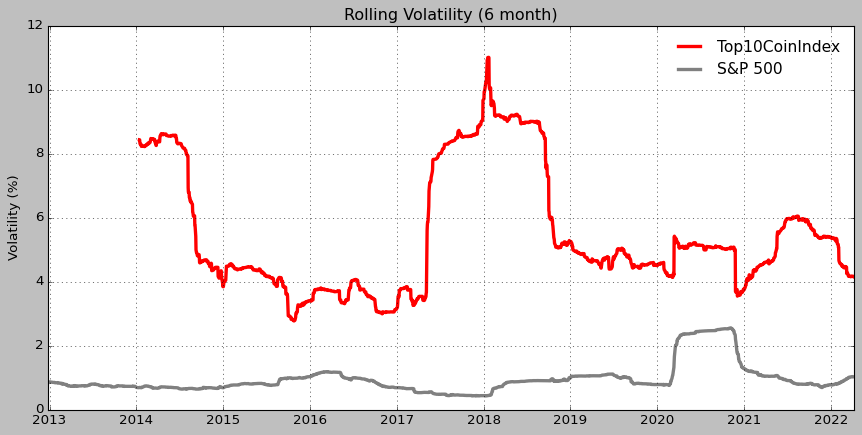

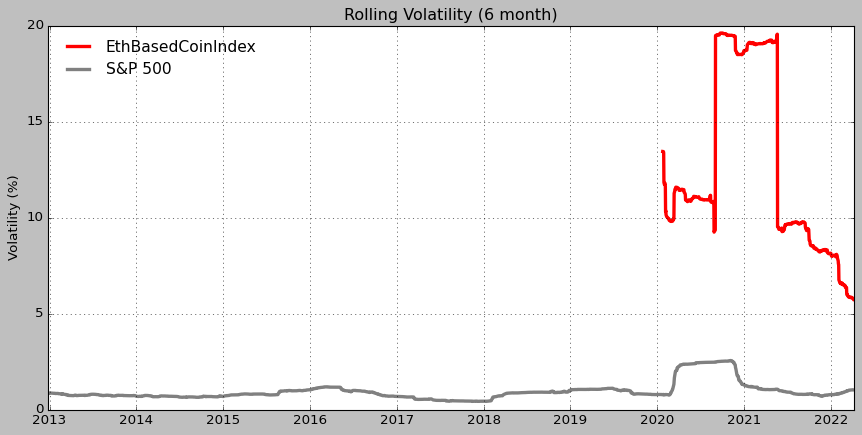

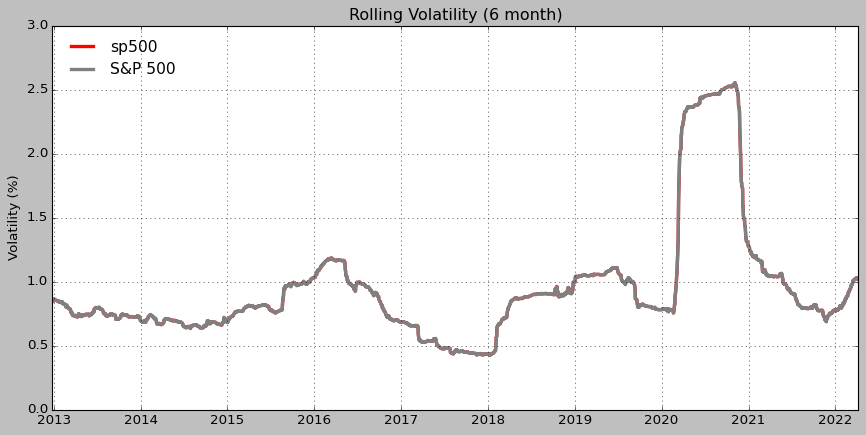

In [217]:
plot_volatility_alone(cryptoindex_volatility_df)

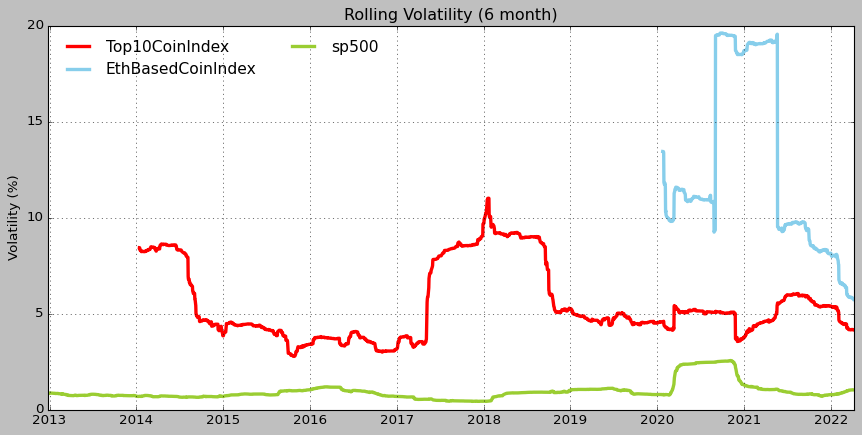

In [218]:
plot_volatility(cryptoindex_volatility_df)